In [14]:
# from sklearn.preprocessing import PolynomialFeatures
import numpy as np
# import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial
# import randcbpside
# import randcbpside2
import games 
# import random
import math
# import pandas as pd
import synthetic_data


class Evaluation_contextual:

    def __init__(self, horizon ):

        self.horizon = horizon

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):#jobid
        context_generator, seed = job
        np.random.seed(seed)
        alg.reset()

        cumRegret =  np.zeros(self.horizon, dtype =float)
        actions = np.zeros(self.horizon, dtype =float)
        alg.reset()

        for t in range(self.horizon):
            # print(t)
            context, distribution = context_generator.get_context(True)
            # distribution = context_generator.get_distribution(context)
            outcome = np.random.choice( 2 , p = distribution )
            # outcome = 0 if distribution[0]<0.5 else 1

            action = alg.get_action(t, context)
            
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, context )

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )
            print(i_star)
            print()

            # regret = game.LossMatrix[action, outcome] - np.min( game.LossMatrix[...,outcome] )

            cumRegret[t] =  val
            actions[t] = action

        return  np.cumsum( cumRegret ) 

In [19]:
dim = 3
horizon = 1000
# nfolds = 10
game = games.apple_tasting(False)
import randcbpside2
import PGTS
import PGIDSratio


class LinearContexts:
    def __init__(self, w):
        self.d = len(w) #number of features
        self.w = w
        self.type = 'linear'
        self.normalize()

    def normalize(self,):
        all = []
        for _ in range(100000):
            c,d = self.get_context(False)
            all.append( c )
        all = np.array(all)
        self.mean = np.mean(all,0)
        self.std = np.std(all,0 )

    def get_context(self, normalize):
        context = np.random.uniform(0, 1,  self.d )
        context = np.array(context).reshape(self.d,1)
        val = self.w @ context
        distribution = [ val[0], 1-val[0] ]
        if normalize:
            context = ( context - self.mean ) / self.std
        return context, distribution
    
    # def get_distribution(self,cont):
    #     
    #     return 

dim = 10
w = np.random.uniform(0, 0.1, 10)
w = w / w.sum()
context_generator = LinearContexts( w ) 

alg = PGTS.PGTS(game, dim,)
# alg = PGIDSratio.PGIDSratio(game, dim,)
# alg = randcbpside2.RandCPBside(game, dim, 1.01, 0.05, 1, 10, 10e-7)

eval = Evaluation_contextual(horizon)

res = eval.eval_policy_once(alg, game, [ context_generator , 0  ] )

1

t 1 action 0 [0.13998628] [0.86001372]
1

t 2 action 0 [0.11619045] [0.88380955]
1

t 3 action 0 [0.0777539] [0.9222461]
1

t 4 action 0 [0.16921354] [0.83078646]
0

t 5 action 0 [0.00015214] [0.99984786]
1

t 6 action 0 [0.44785479] [0.55214521]
1

t 7 action 1 [0.55456625] [0.44543375]
0

t 8 action 1 [0.90760214] [0.09239786]
0

t 9 action 1 [0.76575132] [0.23424868]
1

t 10 action 1 [0.99647701] [0.00352299]
1

t 11 action 0 [0.19767621] [0.80232379]
0

t 12 action 1 [0.90969277] [0.09030723]
0

t 13 action 0 [0.08562101] [0.91437899]
1

t 14 action 0 [0.05219868] [0.94780132]
0

t 15 action 0 [0.00923643] [0.99076357]
0

t 16 action 1 [0.6532109] [0.3467891]
0

t 17 action 1 [0.98649139] [0.01350861]
0

t 18 action 0 [0.38369203] [0.61630797]
0

t 19 action 0 [0.02776625] [0.97223375]
0

t 20 action 1 [0.9810339] [0.0189661]
0

t 21 action 1 [0.81016203] [0.18983797]
1

t 22 action 1 [0.68737186] [0.31262814]
0

t 23 action 0 [0.48854368] [0.51145632]
0

t 24 action 1 [0.789765

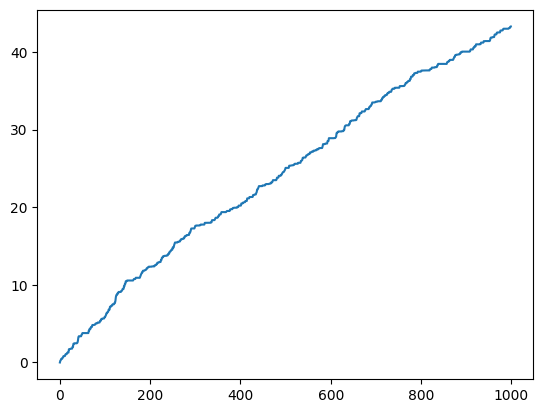

In [20]:
import matplotlib.pyplot as plt
plt.plot( range(horizon), res, label = 'randcbpside' )

In [22]:


dim = 10
w = np.random.uniform(0, 0.1, 10)
w = w / w.sum()
context_generator = LinearContexts( w ) 

all = []
for _ in range(100000):
    c = context_generator.get_context(True)
    all.append( c )

all = np.array(all)


In [25]:
np.std(all,0)

array([[0.99792519],
       [1.00170197],
       [0.99958324],
       [1.00176939],
       [1.00194093],
       [0.99904148],
       [1.0021835 ],
       [0.99837614],
       [1.00367744],
       [0.99638591]])

res3

In [2]:
import numpy as np

class Evaluation:

    def __init__(self, horizon,task):
        self.task = task
        self.horizon = horizon

    def get_outcomes(self, game):
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        alg.reset()
        distribution, jobid, label, nfolds = job
        np.random.seed(jobid)

        outcome_distribution =  {'spam':distribution[0], 'ham':distribution[1]}

        game.set_outcome_distribution( outcome_distribution , jobid )

        action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game )

        for t in range(self.horizon):
            #print(t)

            # Environment chooses one outcome and one context associated to this outcome
            outcome = outcomes[t]

            # policy chooses one action
            # print('t', t,  'outcome', outcome, 'context', context)
            action = alg.get_action(t)

            print('t', t, 'action', action, 'outcome', outcome, )
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, None )

            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:
                    action_counter[i][t] = action_counter[i][t-1]
            
            result = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter

        return  result 


eval = Evaluation(500, 'imbalanced', )
import randcbp
import games
game = games.apple_tasting(False)
alg = randcbp.RandCBP(game,1.01,1/8,10,10e-7)
job = [0.15,1-0.15], 0, None, None
eval.eval_policy_once(alg,game,job)

t 0 action 0 outcome 1
t 1 action 1 outcome 1
rhos [0.0, 0.09296744766583921, 0.18593489533167842, 0.27890234299751765, 0.37186979066335685, 0.46483723832919605, 0.5578046859950353, 0.6507721336608745, 0.7437395813267137, 0.8367070289925529]
0.18593489533167842
t 2 action 0 outcome 1
rhos [0.0, 0.11704164140024731, 0.23408328280049462, 0.35112492420074193, 0.46816656560098924, 0.5852082070012365, 0.7022498484014839, 0.8192914898017312, 0.9363331312019785, 1.0533747726022258]
0.23408328280049462
t 3 action 0 outcome 1
rhos [0.0, 0.13147582534824076, 0.2629516506964815, 0.3944274760447223, 0.525903301392963, 0.6573791267412038, 0.7888549520894446, 0.9203307774376853, 1.051806602785926, 1.1832824281341667]
0.525903301392963
t 4 action 0 outcome 1
rhos [0.0, 0.1416626270255611, 0.2833252540511222, 0.4249878810766833, 0.5666505081022444, 0.7083131351278055, 0.8499757621533666, 0.9916383891789277, 1.1333010162044888, 1.2749636432300497]
0.8499757621533666
t 5 action 0 outcome 1
rhos [0.0, 0.

array([0. , 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
       1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
       1.4, 1.4, 1.4, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1,
       2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1,
       2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5,
       3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.